# Parameter Optimize

本笔记参考了[博客文章](https://www.cnblogs.com/Luv-GEM/p/10693129.html)

在机器学习或者深度学习中，训练模型就是为了优化模型。通常我们是为模型的输出构建一个损失函数，优化的方向就是使得损失函数最小。

在目前的主流的深度学习框架中，所用的优化算法都是基于梯度的算法。

函数的梯度直白地说就是函数值上升最快的方向。

## Gradient Descent Method

### Batch Gradient Descent

批梯度下降中的批是指的全部训练数据，每次迭代的时候，用整个训练集数据来计算损失函数$\mathcal{L}(\theta)$对参数$\theta$的梯度。
那么参数的更新公式为
$$
\theta = \theta - \eta\cdot\nabla_{\theta}\mathcal{L}(\theta)\tag{1}
$$

BGD一次迭代使用了所有训练数据，得到的梯度一定是让模型更复杂的方向，所以这个梯度的反向一定是模型更优的方向。但是，只是为了求得一个反向，却计算了大量的数据，这样在遇到非常大的数据集的时候就很困难。

### Stochastic Gradient Descent

SGD为了解决BGD需要计算大量样本的缺点，提出了每次迭代利用每个样本计算损失函数的梯度
$$
\theta  = \theta  - \eta\cdot\nabla\mathcal{L}_(\theta;x^{(i)};y^{(i)})\tag{2}
$$
SGD每次只计算一个样本，所以它的计算量样比BGD小得多。但是由于单个样本具有极强的随机性，会造成损失函数在收敛过程中发生震荡。

### Mini-Batch Gradient Descent

为了综合BGD和SGD的优点，提出了MBGD。MBGD每次迭代从训练集中中选取一批小样本，即n个样本进行梯度计算(n一般取值为32~到256)。参数更新方式如下
$$
\theta = \theta - \eta\cdot\nabla\mathcal{L}(\theta;x^{(i, i + n)}; y^{(i, i + n)})\tag{3}
$$
由于是从整个训练集中抽取一小批样本作为迭代数据，那么得到的梯度大概率上也会是使得模型更复杂的方向，也就是说其每次迭代都是有效的。

### GDM的缺陷

1. 所有参数使用了相同的学习率
  对于稀疏数据或者特征，有时我们可能想对出现频率低的特征更新快一些，对于常出现的特征更新慢一些。
2. 不能保证良好的的收敛性
  learning rate选择太小，收敛速度会很慢，如果太大，损失函数会在极小值处不停地震荡。对于非凸函数,这三种方法都可能陷入**鞍点**和**局部极小值**。

## 指数加权平均

指数加权平均(exponentially weighted averges)，也叫指数加权移动平均，是一种常用的序列数据处理方式。

直接给出其计算公式
$$
v_t = \beta v_{t - 1} + (1 - \beta)\theta_t\tag{4}
$$

其中
- $\beta$为历史平均的权重，取值为$(0, 1)$
- $v_{t - 1}$到$t - 1$时刻的历史平均
- $\theta_t$当前时刻的数据

公式(4)之所以被称为指数加权平均，原因如下:
  公式(4)本质上是**指数式**衰减加权的平均移动，对于$k \le t$有$v_{k4t} = (1 - \beta)\beta^{t - k}\theta_t$其中$v_{k4t}$代表时刻k的观察值对时刻t的均值贡献的数值。
  
因为加权系数是随着时间以指数形式递减的，时间越靠近，权重越大，越靠前，权重越小。

对于加权系数$\beta$的选择，有如下原则

假如我们以$e^{-1}$为分界点，当权重衰减到这个值后就可以忽略不计，那么，对任意$\beta$，有$\beta^{\frac{1}{1 - \beta}} \approx e^{-1}$， 所有指数加权及时最近$N = \frac{1}{1 - \beta}$的平均值

观察下一个单元格画出的图像，我们分别设置$\beta = 0.5, \beta = 0.8, \beta = 0.9$。可以看到$\beta$越大的时候函数图像越光滑。

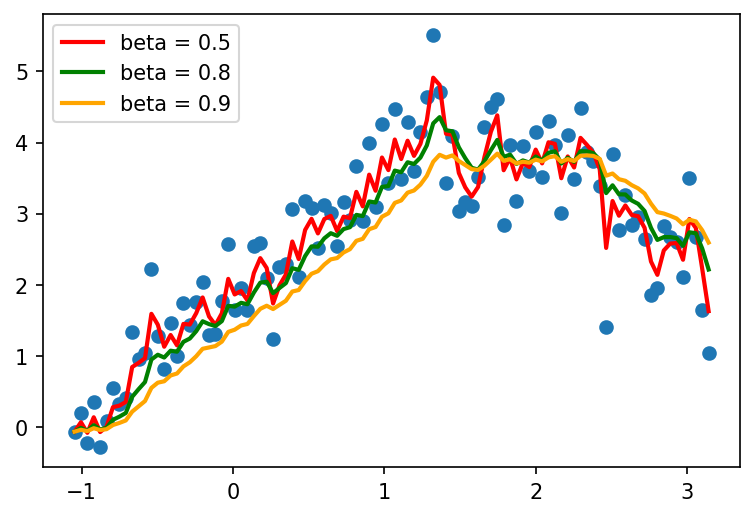

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def exp_average(data: np.array, beta=0.9):
    data = data.reshape(-1)
    result = np.zeros_like(data)
    result[0] = data[0]
    for i in range(1, len(data)):
        result[i] = beta * result[i - 1] + (1 - beta)*data[i]
    return result

plt.figure(dpi=150)
x = np.linspace(-np.pi/3,  np.pi, 100)
y1 = 2* np.sin(x) + 2  + 0.6 * np.random.randn(100)
y2 = exp_average(y1, 0.5)
y3 = exp_average(y1, 0.8)
y4 = exp_average(y1)
plt.scatter(x, y1)
plt.plot(x, y2, c="r", linewidth=2, label="beta = 0.5")
plt.plot(x, y3, c="g", linewidth=2, label="beta = 0.8")
plt.plot(x, y4, c="orange", linewidth=2, label="beta = 0.9")
plt.legend()
plt.show()

## 调整学习率

从梯度下降算法的经验上看，学习率在一开始要保持比较大些来保证收敛速度，在收敛到最小点附近要小点以避免来回震荡。因此，比较直接的学习率调整可以通过学习率衰减的方式来实现。

而学习率衰减又分为：
1. 固定衰减率的调整学习率方法：逆时衰减、指数衰减、自然指数衰减。

2. 自适应地调整学习率的方法：AdaGrad、RMSprop，AdaDelta。

假设初始化学习率为$\alpha_0$，在第$t$次迭代时的学习率为$\alpha_t$，固定衰减率的方法设置为按迭代次数衰减。

### 逆时衰减
$$
\alpha_t = \alpha_0\frac{1}{1 + \beta t}\tag{5}
$$
### 指数衰减
$$
\alpha_t = \alpha_0\beta^t\tag{6}
$$
### 自然指数衰减
$$
\alpha_t = \frac{\alpha_0}{e^{\beta t}}\tag{7}
$$

### AdaGrad
AdaGrad(Adaptive Gradient)算法是借鉴L2[正则化](../ml/regularization.ipynb)的思想，每次迭代时自适应地调整每个参数的学习率。在第$t$次迭代时，先计算每个参数梯度平方的累计值：
$$
G_t = \displaystyle\sum_{\tau = 1}^tg_\tau\odot g_\tau\tag{8}
$$

$g_\tau$表示第$\tau$次迭代时的梯度，梯度平方是按元素进行乘积。AdaGrad算法的参数更新值为：
$$
\Delta\theta_t = -\frac{\alpha}{\sqrt{G_t + \varepsilon}}\odot g_t\tag{9}
$$
其中$\alpha$为初始的学习率，$\varepsilon$是为保持数值稳定而设置的非常小的常数。在AdaGrad算法中，如果某个参数的偏导数累计非常大，其学习率相对比较小；相反则比较大；但整体上随着迭代次数增加，学习率逐渐缩小。

### RMSprop
RMSprop(Root Mean Square prop)算法可以在某些情况下避免AdaGrad算法中学习率不断单调下降以至于过早衰减的缺点。

RMSprop算法首先计算每次迭代梯度$g_t$平方的指数衰减移动平均：
$$
\begin{aligned}
G_t =&\beta G_{t - 1} - (1 - \beta)g_t\odot g_t\\
=&(1 - \beta)\displaystyle\sum_{\tau = 1}^t\beta^{t - \tau}g_\tau\odot g_\tau
\end{aligned}\tag{10}
$$
公式(10)是公式(4)的一个应用，将其中的观测值换成了每次迭代求得的梯度
$$
\Delta\theta_t = -\frac{\alpha}{\sqrt{G_t + \varepsilon}}\odot g_t\tag{11}
$$
RMSprop算法和AdaGrad算法的区别在于Gt的计算由累积的方式变成了指数衰减移动平均。在迭代中，每个参数的学习率不是呈衰减趋势，而是可以变小也可以变大。

### AdaDelta
AdaDelta算法也是AdaGrad算法的一个改进。和RMSprop算法类似，AdaDelta算法通过梯度平方的指数衰减移动平均来调整学习率，而它的创新在于引入了每次参数更新之差Δθ的平方的指数衰减权移动平均。

在第t次迭代时，首先计算一个参数更新差Δθt的指数衰减权移动平均：
$$
\Delta X^2_{t - 1} = \beta_1\Delta X^2_{t - 2} + (1 - \beta_1)\Delta\theta_{t - 1}\odot\theta_{t - 1}\tag{12}
$$
则AdaDelta算法的参数更新差为：
$$
\Delta\theta_t = -\frac{\sqrt{\Delta X^2_{t - 1}  + \varepsilon}}{\sqrt{G_t + \varepsilon}}\odot g_t\tag{13}
$$
其中$G_t$由公式(10)算出，$\Delta X^2_{t - 1}$是参数更新差$\Delta\theta_t$的指数衰减权移动平均。

AdaDelta算法将RMSprop算法中的初始学习率$\alpha$改为了动态计算的，在一定程度上平抑了学习率的波动。

## 稳定梯度方向的方法

在小批量梯度下降中，如果每次选取样本的数量比较小，得到的梯度值和所有样本计算后的梯度值可能出现波动性的误差，表现为梯度方向不稳定。那么损失会呈现震荡下降的形态。那么，就需要设计方法来稳定方向。

### Momentum Method
带动量的梯度下降法也是一种很常用的的优化算法。就像物体的惯性一样，它能减小物体受左右变化的力作用的效果。

打个比方，一个球顺着斜坡往下滚动，会因为地心引力的原因而一直加速，速度越来越快的往坡低滚去。梯度下降法中的Momentum就和地心引力的作用很类似，能够让梯度下降法沿着下降的方向逐渐扩大幅度。起到对梯度下降法进行加速的作用

参数更新公式写作
$$
\Delta\theta_t = \rho\Delta\theta_{t - 1} - \alpha g_t\tag{14}
$$
其中$\rho$为动量因子，通常设为$0.9$，$\alpha$是学习率。

这样，每个参数的实际更新差值取决于最近一段时间内梯度的加权平均值。当某个参数在最近一段时间内的梯度方向不一致时，其真实的参数更新幅度变小；相反，当在最近一段时间内的梯度方向都一致时，其真实的参数更新幅度变大，起到加速作用。一般而言，在迭代初期，梯度方法都比较一致，动量法会起到加速作用，可以更快地到达最优点。在迭代后期，梯度方法会不一致，在收敛值附近震荡，动量法会起到减速作用，增加稳定性 。

### Nesterov加速梯度
Nesterov加速梯度(Nesterov Accelerated Gradient)，是一种对动量法的改进。在动量法中，实际的参数更新方向$\Delta\theta_t$为上一步的参数更新方向$\Delta\theta_{t - 1}$和当前的梯度$-g_t$的叠加。而NAG的改进在于，把当前的负梯度$-\nabla_{\theta_{t - 1}}\mathcal{L}(\theta_{t-1})$，修正为损失函数在$(\theta_{t-1}+\rho\Delta\theta_{t - 1})$上的负梯度: $-\nabla_{\theta_{t - 1}}\mathcal{L}(\theta_{t-1}+\rho\Delta\theta_{t-1})$

则参数更新的方向为：
$$
\Delta\theta_t = \rho\Delta\theta_{t - 1} - \alpha\nabla_{\theta_{t - 1}} \mathcal{L}(\theta_{t - 1}  + \rho\Delta\theta_{t - 1})\tag{15}
$$
在实际的工作中，使用的是下列公式
$$
\Delta\theta_t = \rho^2\Delta\theta_{t - 1} - (1 + \rho)\alpha\nabla_{\theta_{t - 1}}\mathcal{L}(\theta_{t - 1})\tag{16}
$$
注意，$ \nabla_{\theta_{t - 1}}\mathcal{L}(\theta_{t - 1}) = g_t$


公式(15),(16)是等价的，证明如下
首先令$\theta'_{t - 1} = \theta_{t - 1} + \rho\Delta\theta_{t - 1}$, 则有$\Delta\theta_t = \rho\Delta\theta_{t - 1} - \alpha g_t(\theta'_{t - 1})$, 那么


$$
\begin{aligned}\theta'_t =& \theta_t + \rho\Delta\theta_t\\=& \theta_{t - 1} + \Delta\theta_t + \rho\Delta\theta_t\\=& \theta_{t - 1} + (1 + \rho) \Delta\theta_t\\=& \theta'_{t - 1} - \rho\Delta\theta_{t - 1} + (1 + \rho)\left[\rho\Delta\theta_{t - 1} - \alpha g_t(\theta'_{t - 1})\right]\\=& \theta'_{t - 1} + \rho^2\Delta\theta_{t - 1} - (1 + \rho)\alpha\nabla_{\theta_{t - 1}}\mathcal{L}(\theta_{t - 1})
\end{aligned}\tag{17}
$$


令$\theta_{t - 1} = \theta'_t$，公式(16)表示为
$$
\theta_t = \theta_{t - 1} + \rho^2\Delta\theta_{t - 1} - (1 + \rho)\alpha\nabla_{\theta_{t - 1}}\mathcal{L}(\theta_{t - 1})\tag{18}
$$
则公式(16)得证

### Adam
Adam算法(Adaptive Moment Estimation)可以看作是Momentum method和RMSprop的结合，不但使用动量作为参数更新方向，而且可以自适应地调整学习率。

Adam 算法一方面计算梯度平方$g_t^2$的指数加权平均(和RMSprop类似)，用于自适应地调整学习率，另一方面计算梯度$g_t$的指数加权平均（与动量法类似），作为参数调整方向。
$$
M_t = \beta_1M_{t - 1} + (1 - \beta_1)g_t\tag{19}
$$

$$
G_t = \beta_2G_{t - 1} + (1 - \beta_2)g_t\odot g_t\tag{20}
$$

其中$\beta_1$和$\beta_2$分别为两个移动平均的衰减率，通常取值为$\beta_2 = 0.9$， $\beta_2 = 0.99$

$M_t$可以看作是梯度的均值(一阶矩)，$G_t$可以看作是梯度的未减去均值的方差，假设$M_0= 0$, $G_0= 0$，那么在迭代初期$M_t$和$G_t$的值会比真实的均值和方差要小。特别是当$\beta_1$和$\beta_2$都接近于1时，偏差会很大。因此，需要对偏差进行修正。
$$
\hat{M}_t =\frac{M_t}{1 - \beta_1^t}\tag{21}
$$

$$
\hat{G}_t =\frac{G_t}{1 - \beta_2^t}\tag{22}
$$

Adam算法的参数更新值为：
$$
\Delta\theta_t = -\frac{\alpha}{\sqrt{\hat{G}_t + \varepsilon}}\hat{M}_t\tag{23}
$$

其中学习率$\alpha_0$通常设为0.001，并且也可以按照迭代次数$t$进行衰减，比如：
$$
\alpha_t = \frac{\alpha_0}{\sqrt{t}}\tag{24}
$$